# Harnessing Machine Learning for Healthcare: Predicting Death Events of Patients with Prior Heart Failure

## Exploratory Data Analysis

One of machine learning's most significant applications is diagnosing and predicting future outcomes of patients, given their demographics and medical histories. By harnessing the data to classify patients as "high risk", healthcare professionals can administer more specialized care and implement proactive measures to save the lives of many.

This project aims to analyze the characteristics of 299 patients who have experienced heart failure. The target variable of the dataset is a death event, denoting whether a patient died during the follow-up period. Patient features include demographics like age and sex, along with medical statistics like CPK level, platelet count, and etc. Following the exploratory data analysis (EDA), modeling will be performed using a multitude of different machine learning models to compare and achieve the highest accuracy. Lastly, a dashboard will be implemented to showcase key statistics, modeling outcomes, and predictions on input patient statistics.

In [1]:
__author__ = 'Jared Paul Guevara'

In [2]:
# Import necessary libraries for gathering, manipulating, and visualizing data
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# Fetching dataset from UCI's Machine Learning Repository
heart_failure_data = fetch_ucirepo(id=519)

# Separating features from target variable
X = heart_failure_data.data.features
y = heart_failure_data.data.targets

# Print size and descriptions of dataset
print('Size of dataset:', len(X))
assert(len(X) == len(y))
display(heart_failure_data['variables'][['name', 'description', 'units']])

# Assert that there are no missing/null values in dataset
assert(X.isnull().values.any() == False)

Size of dataset: 299


,name,description,units
0,age,age of the patient,years
1,anaemia,decrease of red blood cells or hemoglobin,None
2,creatinine_phosphokinase,level of the CPK enzyme in the blood,mcg/L
3,diabetes,if the patient has diabetes,None
4,ejection_fraction,percentage of blood leaving the heart at each ...,%
5,high_blood_pressure,if the patient has hypertension,None
6,platelets,platelets in the blood,kiloplatelets/mL
7,serum_creatinine,level of serum creatinine in the blood,mg/dL
8,serum_sodium,level of serum sodium in the blood,mEq/L
9,sex,woman or man,None


In [3]:
# Split data into training and testing sets to avoid model bias and overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Assert that training and test sets are of correct size
assert(len(X_train) > len(X_test))
assert(len(X_train) == round(299 - (299 * 0.33)))
assert(len(X_test) == round(299 * 0.33))
print('Size of training data:', len(X_train))
print('Size of test data:', len(X_test))

Size of training data: 200
Size of test data: 99


In [4]:
# Create training data by joining the training sets of features and target variable
train = X_train.join(y_train)
train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
101,75.0,0,582,0,45,1,263358.03,1.18,137,1,0,87,0
69,65.0,0,113,1,25,0,497000.00,1.83,135,1,0,67,1
31,85.0,0,23,0,45,0,360000.00,3.00,132,1,0,28,1
172,70.0,1,171,0,60,1,176000.00,1.10,145,1,1,146,0
148,75.0,1,582,0,30,0,225000.00,1.83,134,1,0,113,1


In [5]:
# Group data by the death event to summarize differences between patient groups
train_grouped = train.groupby('death_event').mean()
train_grouped

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
death_event,,,,,,,,,,,,
0,58.977171,0.417808,565.520548,0.390411,40.383562,0.349315,260978.522192,1.161575,137.178082,0.650685,0.315068,157.842466
1,64.944444,0.425926,629.388889,0.407407,33.759259,0.407407,257836.077407,1.989815,135.111111,0.592593,0.277778,68.555556


At a quick glance, we can see some key differences between patients who survived and those who died. Patients who died during the follow-up period tended to be older with higher levels of CPK, lower ejection fractions, higher creatinine levels in serum, and a far shorter follow-up period. More subtle differences are observed within the other features, which will be looked at more closely through visualizations.

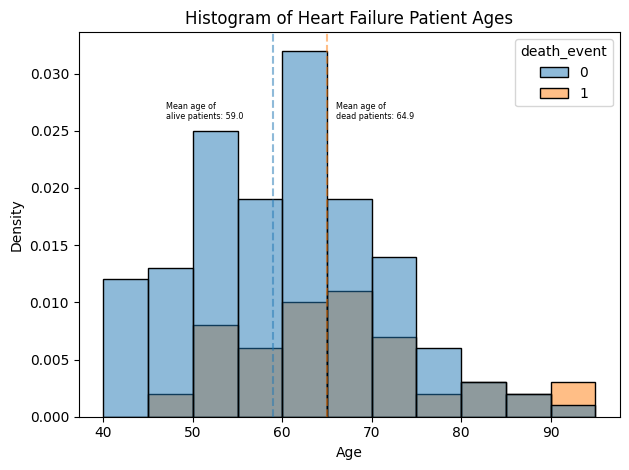

In [6]:
# Plotting the differences in age
sns.histplot(train, x='age', 
             hue='death_event',
             stat='density',
             binwidth=5)
plt.axvline(train_grouped['age'][0],
            alpha=0.5, 
            c='tab:blue',
            ls='--')
plt.axvline(train_grouped['age'][1],
            alpha=0.5,
            c='tab:orange',
            ls='--'),
plt.annotate(f"Mean age of\nalive patients: {train_grouped['age'][0]:.1f}",
             xy=(train_grouped['age'][0], 0.025),
             xytext=(47, 0.026),
             size='xx-small')
plt.annotate(f"Mean age of\ndead patients: {train_grouped['age'][1]:.1f}",
             xy=(train_grouped['age'][1], 0.025),
             xytext=(66, 0.026),
             size='xx-small')
plt.title('Histogram of Heart Failure Patient Ages')
plt.xlabel('Age')
plt.tight_layout() 

In [7]:
bins = np.arange(40, 105, 5)
bins
train_binned = pd.cut(train['age'], bins, right=False, include_lowest=True)
train_binned = pd.concat([train_binned, train['death_event']], axis=1)
train_group_binned = train_binned.groupby(['death_event', 'age'], observed=False).size().reset_index(name='count')
train_alive_binned, train_dead_binned = [pd.DataFrame(x).reset_index() for x in np.array_split(train_group_binned, 2)]
age_bin_ratios = train_alive_binned.drop(['index', 'death_event'], axis=1)
age_bin_ratios['dead_count'] = train_dead_binned['count']
age_bin_ratios.at[10, 'dead_count'] += age_bin_ratios.at[11, 'dead_count']
age_bin_ratios = age_bin_ratios.drop(11)
age_bin_ratios['alive_ratio'] = round(age_bin_ratios['count'] / (age_bin_ratios['count'] + age_bin_ratios['dead_count']), 2)
age_bin_ratios

/home/jaredpaulgue/.local/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,age,count,dead_count,alive_ratio
0,"[40, 45)",12,0,1.00
1,"[45, 50)",13,2,0.87
2,"[50, 55)",25,8,0.76
3,"[55, 60)",19,6,0.76
4,"[60, 65)",32,10,0.76
5,"[65, 70)",19,11,0.63
6,"[70, 75)",14,7,0.67
7,"[75, 80)",6,2,0.75
8,"[80, 85)",3,3,0.50
9,"[85, 90)",2,2,0.50


The potential effects of age in patients is more pronounced once the data is plotted out, as the ratio of living to dead patients generally decreases as age increases. 

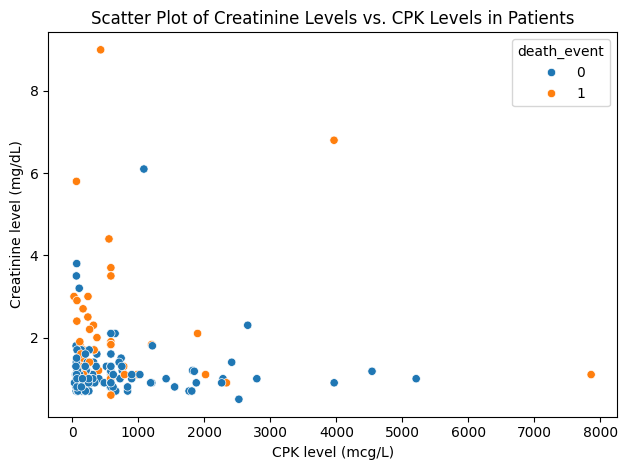

In [8]:
# Creatine <-CPK-> phosphocreatine -breakdown-> creatinine (waste product)
sns.scatterplot(train, x='creatinine_phosphokinase', y='serum_creatinine', hue='death_event')
plt.title('Scatter Plot of Creatinine Levels vs. CPK Levels in Patients')
plt.xlabel('CPK level (mcg/L)')
plt.ylabel('Creatinine level (mg/dL)')
plt.tight_layout()


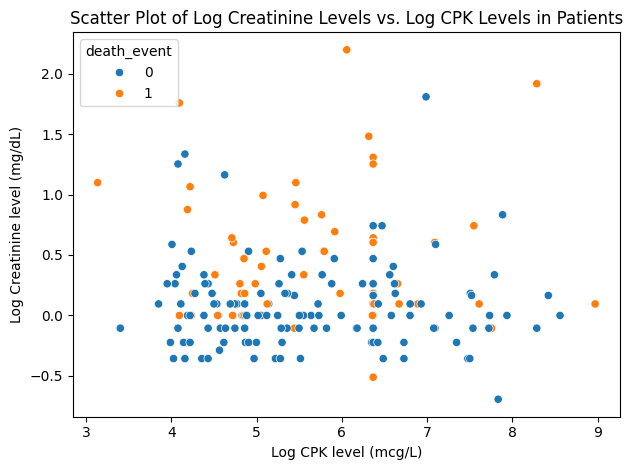

In [9]:
sns.scatterplot(train, x=np.log(train['creatinine_phosphokinase']), y=np.log(train['serum_creatinine']), hue='death_event')
plt.title('Scatter Plot of Log Creatinine Levels vs. Log CPK Levels in Patients')
plt.xlabel('Log CPK level (mcg/L)')
plt.ylabel('Log Creatinine level (mg/dL)')
plt.tight_layout()

38


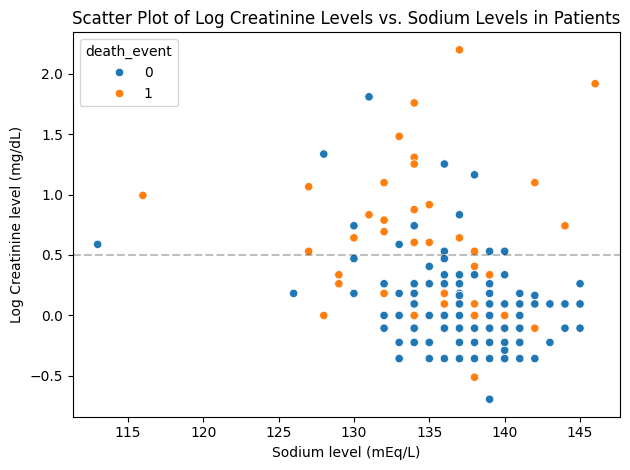

In [10]:
sns.scatterplot(train, x='serum_sodium', y=np.log(train['serum_creatinine']), hue='death_event')
plt.title('Scatter Plot of Log Creatinine Levels vs. Sodium Levels in Patients')
plt.axhline(0.5,
            alpha=0.25,
            c='black',
            ls='--')
plt.xlabel('Sodium level (mEq/L)')
plt.ylabel('Log Creatinine level (mg/dL)')
plt.tight_layout()
print(len(train[np.log(train['serum_creatinine']) > 0.5]))

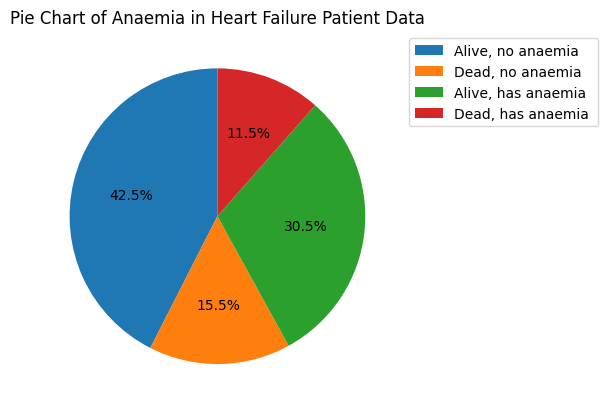

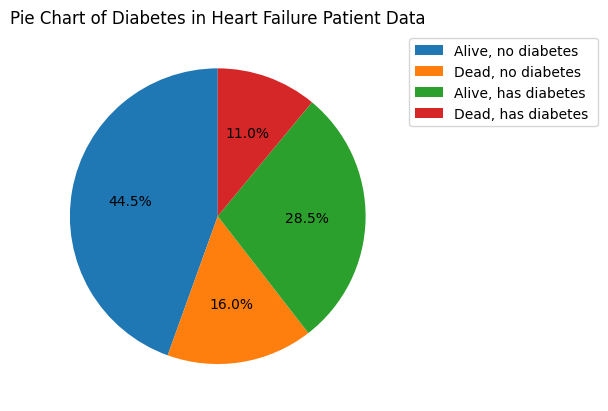

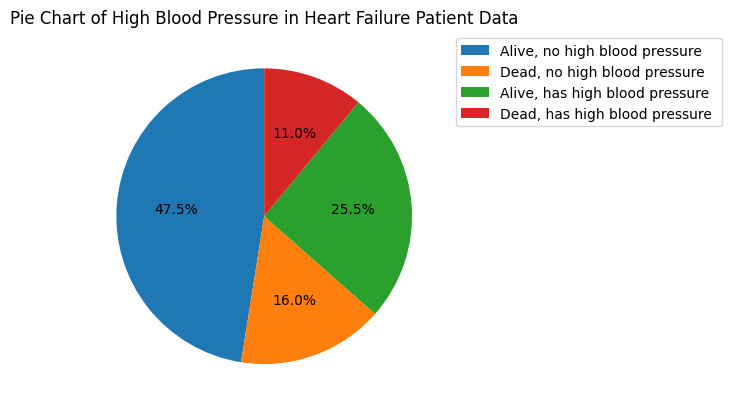

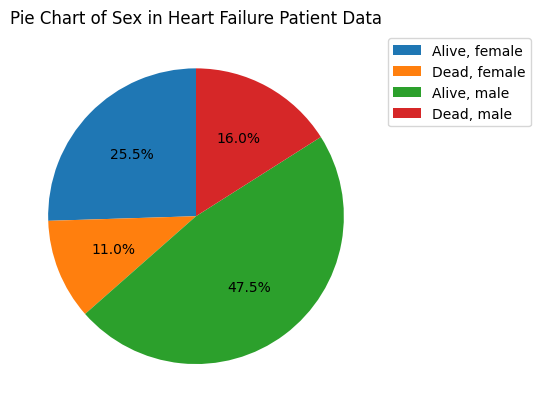

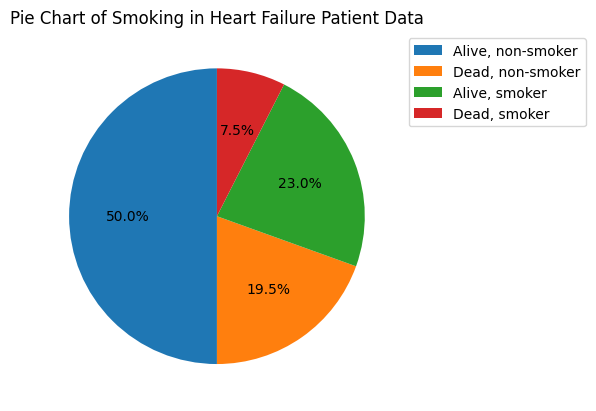

In [11]:
binary_var = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

for var in binary_var:
    group = train.groupby([var, 'death_event']).size().reset_index(name='count')
    total = group['count'].sum()
    group['percent'] = group['count'] / total * 100

    plt.pie(group['percent'], autopct='%1.1f%%', startangle=90)
    plt.title(f'Pie Chart of {"".join(x[0].upper() + x[1:] + " " for x in var.split("_"))}in Heart Failure Patient Data')
    if var in ['anaemia', 'diabetes', 'high_blood_pressure']:
        plt.legend([f'Alive, no {"".join(x + " " for x in var.split("_"))}', f'Dead, no {"".join(x + " " for x in var.split("_"))}', f'Alive, has {"".join(x + " " for x in var.split("_"))}', f'Dead, has {"".join(x + " " for x in var.split("_"))}'],
                   bbox_to_anchor=(1, 1))
    elif var == 'sex':
        plt.legend([f'Alive, female', f'Dead, female', f'Alive, male', f'Dead, male'],
                   bbox_to_anchor=(1, 1))
    elif var == 'smoking':
        plt.legend([f'Alive, non-smoker', f'Dead, non-smoker', f'Alive, smoker', f'Dead, smoker'],
                   bbox_to_anchor=(1, 1))
    plt.show()

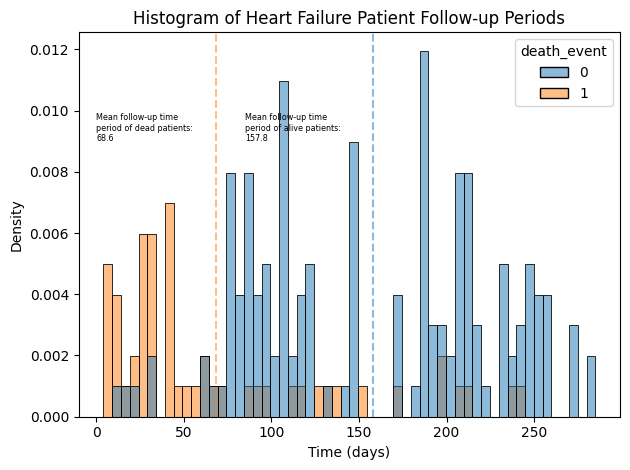

In [12]:
sns.histplot(train, x='time', 
             hue='death_event',
             stat='density',
             binwidth=5)
plt.axvline(train_grouped['time'][0],
            alpha=0.5, 
            c='tab:blue',
            ls='--')
plt.axvline(train_grouped['time'][1],
            alpha=0.5,
            c='tab:orange',
            ls='--'),
plt.annotate(f"Mean follow-up time\nperiod of alive patients:\n{train_grouped['time'][0]:.1f}",
             xy=(train_grouped['time'][0], 0.010),
             xytext=(85, 0.009),
             size='xx-small')
plt.annotate(f"Mean follow-up time\nperiod of dead patients:\n{train_grouped['time'][1]:.1f}",
             xy=(train_grouped['time'][1], 0.010),
             xytext=(0, 0.009),
             size='xx-small')
plt.title('Histogram of Heart Failure Patient Follow-up Periods')
plt.xlabel('Time (days)')
plt.tight_layout() 

Text(0.5, 1.0, 'Correlation Matrix of Heart Failure Patient Features')

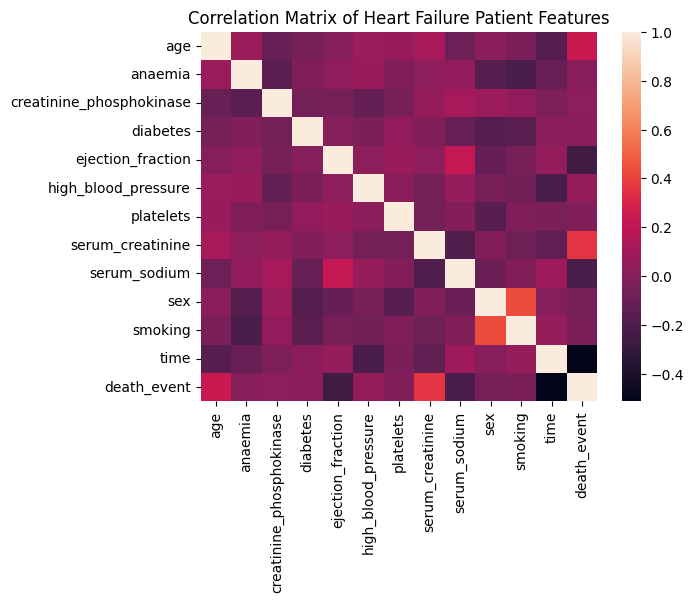

In [13]:
sns.heatmap(train.corr())
plt.title('Correlation Matrix of Heart Failure Patient Features')

In [14]:
top_corr = train.corr().unstack().sort_values(ascending=False).drop_duplicates()

top_corr[(top_corr >= 0.5) | (top_corr <= -0.5)][1:]

time  death_event   -0.512018
dtype: float64

In [26]:
train.to_csv('data/heart_failure_train.csv', index=False)
X_test.to_csv('data/heart_failure_test_X.csv', index=False)
y_test.to_csv('data/heart_failure_test_y.csv', index=False)